<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/googlenet/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [4]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [5]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [6]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [9]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [10]:
net = models.googlenet(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 178MB/s]


In [11]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.6481 Acc: 0.6458
valLoss: 0.6200 Acc: 0.8000
trainLoss: 0.6182 Acc: 0.6958
valLoss: 0.6167 Acc: 0.8000
trainLoss: 0.6298 Acc: 0.7083
valLoss: 0.6164 Acc: 0.7833
trainLoss: 0.6268 Acc: 0.6917
valLoss: 0.6136 Acc: 0.8000
trainLoss: 0.6103 Acc: 0.7542
valLoss: 0.6150 Acc: 0.8000
trainLoss: 0.6061 Acc: 0.7583
valLoss: 0.6106 Acc: 0.8000
trainLoss: 0.6124 Acc: 0.7500
valLoss: 0.6078 Acc: 0.8000
trainLoss: 0.6138 Acc: 0.7167
valLoss: 0.6168 Acc: 0.7667
trainLoss: 0.6083 Acc: 0.7375
valLoss: 0.6149 Acc: 0.7667
trainLoss: 0.6209 Acc: 0.7375
valLoss: 0.6112 Acc: 0.7667
trainLoss: 0.6043 Acc: 0.7667
valLoss: 0.6040 Acc: 0.7833
trainLoss: 0.6047 Acc: 0.7708
valLoss: 0.5983 Acc: 0.7833
trainLoss: 0.6087 Acc: 0.7250
valLoss: 0.5966 Acc: 0.8000
trainLoss: 0.6073 Acc: 0.7375
valLoss: 0.5906 Acc: 0.8000
trainLoss: 0.6058 Acc: 0.7500
valLoss: 0.5907 Acc: 0.8000
trainLoss: 0.5879 Acc: 0.7583
valLoss: 0.5922 Acc: 0.8167
trainLoss: 0.5877 Acc: 0.758

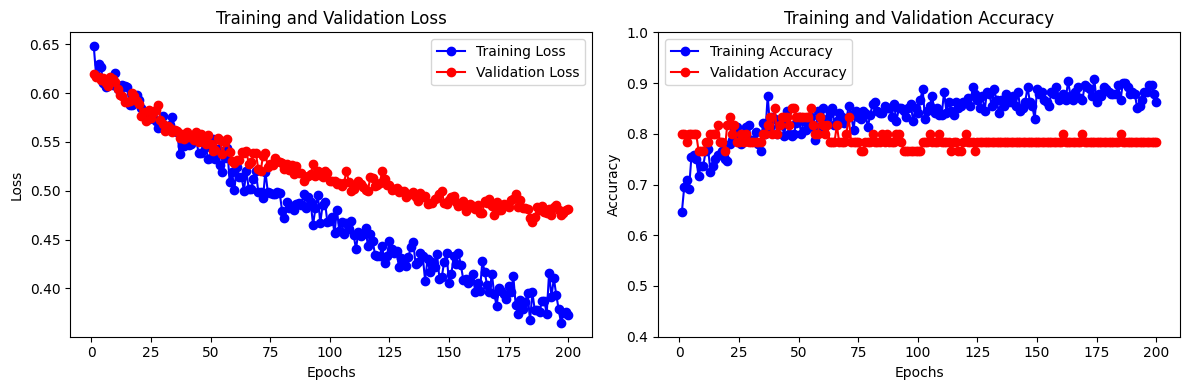

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.88      0.82      0.85        45
         out       0.56      0.67      0.61        15

    accuracy                           0.78        60
   macro avg       0.72      0.74      0.73        60
weighted avg       0.80      0.78      0.79        60

==========Cross Validation Fold 2==========
trainLoss: 0.6705 Acc: 0.5958
valLoss: 0.6999 Acc: 0.4167
trainLoss: 0.6651 Acc: 0.6250
valLoss: 0.6955 Acc: 0.4667
trainLoss: 0.6646 Acc: 0.6125
valLoss: 0.6893 Acc: 0.4833
trainLoss: 0.6377 Acc: 0.6750
valLoss: 0.6822 Acc: 0.5000
trainLoss: 0.6481 Acc: 0.6542
valLoss: 0.6703 Acc: 0.5333
trainLoss: 0.6460 Acc: 0.6583
valLoss: 0.6624 Acc: 0.5500
trainLoss: 0.6341 Acc: 0.7083
valLoss: 0.6561 Acc: 0.6667
trainLoss: 0.6317 Acc: 0.7292
valLoss: 0.6539 Acc: 0.6500
trainLoss: 0.6357 Acc: 0.7042
valLoss: 0.6482 Acc: 0.6500
trainLoss: 0.6197 Acc: 0.7042
valLoss: 0.6426 Acc: 0.6500
trainLoss: 0.6196 Acc: 0

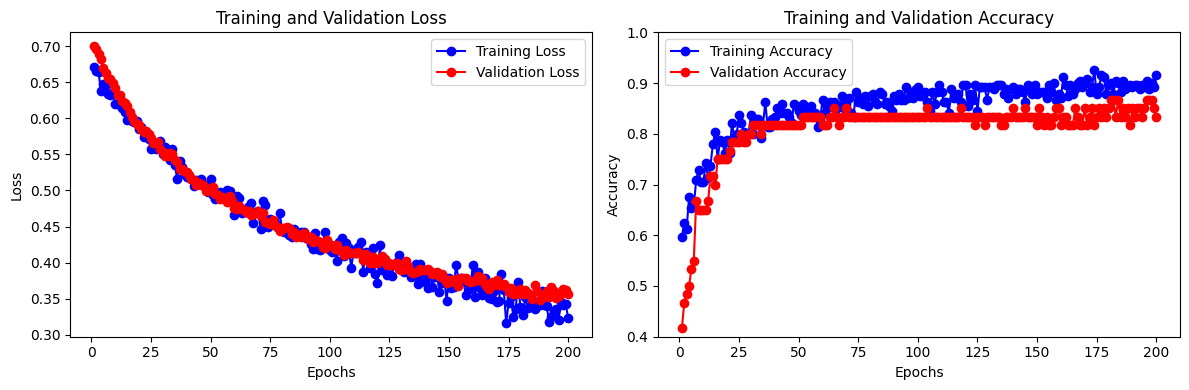

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.91      0.87      0.89        45
         out       0.65      0.73      0.69        15

    accuracy                           0.83        60
   macro avg       0.78      0.80      0.79        60
weighted avg       0.84      0.83      0.84        60

==========Cross Validation Fold 3==========
trainLoss: 0.6829 Acc: 0.5583
valLoss: 0.6599 Acc: 0.6667
trainLoss: 0.6644 Acc: 0.6208
valLoss: 0.6502 Acc: 0.6833
trainLoss: 0.6667 Acc: 0.6125
valLoss: 0.6389 Acc: 0.7000
trainLoss: 0.6467 Acc: 0.6708
valLoss: 0.6292 Acc: 0.7167
trainLoss: 0.6199 Acc: 0.7583
valLoss: 0.6177 Acc: 0.7833
trainLoss: 0.6305 Acc: 0.6625
valLoss: 0.6088 Acc: 0.7667
trainLoss: 0.6105 Acc: 0.7917
valLoss: 0.5988 Acc: 0.7833
trainLoss: 0.5905 Acc: 0.8083
valLoss: 0.5913 Acc: 0.8000
trainLoss: 0.6012 Acc: 0.7625
valLoss: 0.5824 Acc: 0.8000
trainLoss: 0.5863 Acc: 0.8250
valLoss: 0.5782 Acc: 0.8000
trainLoss: 0.5754 Acc: 0

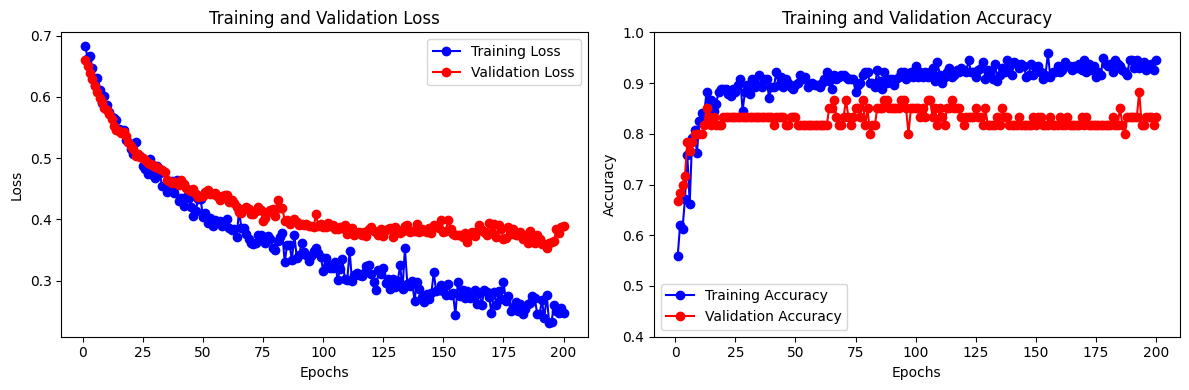

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.91      0.87      0.89        45
         out       0.65      0.73      0.69        15

    accuracy                           0.83        60
   macro avg       0.78      0.80      0.79        60
weighted avg       0.84      0.83      0.84        60

==========Cross Validation Fold 4==========
trainLoss: 0.6894 Acc: 0.4708
valLoss: 0.6765 Acc: 0.4167
trainLoss: 0.6798 Acc: 0.4792
valLoss: 0.6577 Acc: 0.5167
trainLoss: 0.6669 Acc: 0.5667
valLoss: 0.6425 Acc: 0.5167
trainLoss: 0.6502 Acc: 0.5875
valLoss: 0.6283 Acc: 0.6000
trainLoss: 0.6519 Acc: 0.5833
valLoss: 0.6184 Acc: 0.6667
trainLoss: 0.6375 Acc: 0.6750
valLoss: 0.6007 Acc: 0.7667
trainLoss: 0.6136 Acc: 0.7458
valLoss: 0.5970 Acc: 0.7500
trainLoss: 0.6099 Acc: 0.7750
valLoss: 0.5835 Acc: 0.7667
trainLoss: 0.6091 Acc: 0.7083
valLoss: 0.5720 Acc: 0.8500
trainLoss: 0.6062 Acc: 0.7583
valLoss: 0.5602 Acc: 0.8833
trainLoss: 0.5807 Acc: 0

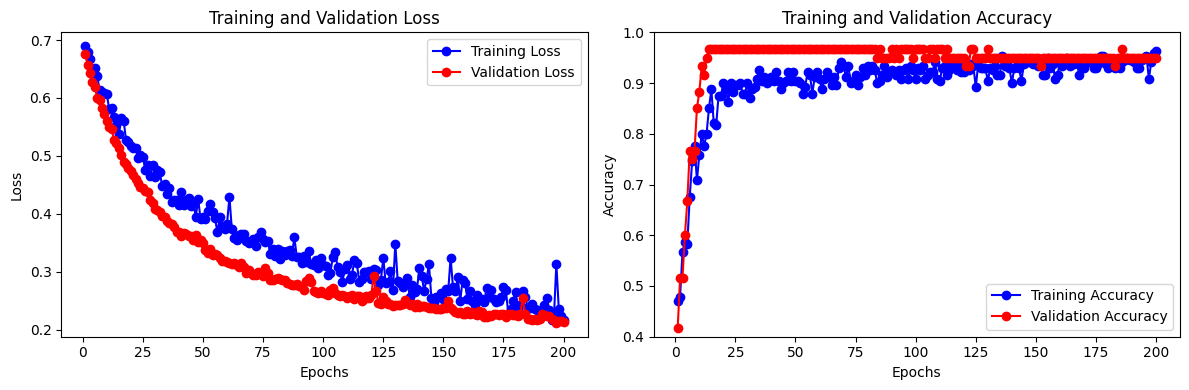

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.94      1.00      0.97        45
         out       1.00      0.80      0.89        15

    accuracy                           0.95        60
   macro avg       0.97      0.90      0.93        60
weighted avg       0.95      0.95      0.95        60

==========Cross Validation Fold 5==========
trainLoss: 0.6320 Acc: 0.6875
valLoss: 0.6222 Acc: 0.5000
trainLoss: 0.6274 Acc: 0.6292
valLoss: 0.6143 Acc: 0.5167
trainLoss: 0.6098 Acc: 0.6958
valLoss: 0.6005 Acc: 0.5500
trainLoss: 0.5874 Acc: 0.7750
valLoss: 0.5869 Acc: 0.6333
trainLoss: 0.5929 Acc: 0.7625
valLoss: 0.5762 Acc: 0.7000
trainLoss: 0.5704 Acc: 0.8292
valLoss: 0.5618 Acc: 0.8333
trainLoss: 0.5715 Acc: 0.8333
valLoss: 0.5485 Acc: 0.8833
trainLoss: 0.5603 Acc: 0.8667
valLoss: 0.5354 Acc: 0.9000
trainLoss: 0.5388 Acc: 0.9042
valLoss: 0.5261 Acc: 0.9500
trainLoss: 0.5337 Acc: 0.8833
valLoss: 0.5134 Acc: 0.9833
trainLoss: 0.5189 Acc: 0

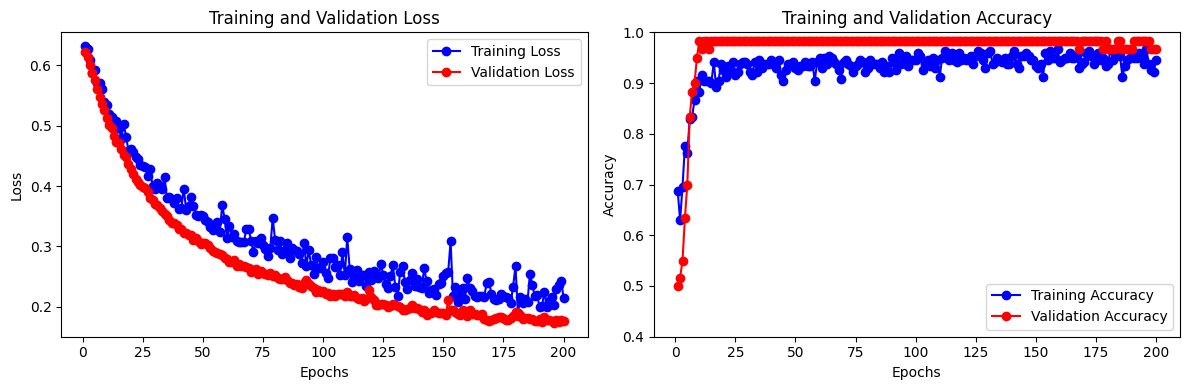

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      0.98      0.98        46
         out       0.93      0.93      0.93        14

    accuracy                           0.97        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.97      0.97      0.97        60



In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.fc = nn.Linear(net.fc.in_features, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))

In [15]:
# ライブラリのバージョンを確認する
import matplotlib
import numpy
import torch
import torchvision
import pandas
import sklearn

print("matplotlib version:", matplotlib.__version__)
print("numpy version:", numpy.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("pandas version:", pandas.__version__)
print("sklearn version:", sklearn.__version__)


matplotlib version: 3.7.1
numpy version: 1.26.4
torch version: 2.3.0+cpu
torchvision version: 0.18.0+cpu
pandas version: 2.1.4
sklearn version: 1.3.2


Grand-cam class

In [ ]:
target_layer = net.classifier[6]
feature, feature_grad = None, None

# フック関数
def forward_hook(module, inputs, outputs):
    global feature
    feature = outputs.detach().cpu()

def backward_hook(module, grad_inputs, grad_outputs):
    global feature_grad
    feature_grad = grad_outputs[0].detach().cpu()

# フックの登録
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)